In [3]:
#visualizing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#data pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

In [4]:
data = pd.read_csv('Breast Cancer METABRIC.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

In [5]:
# Checking if all Patient_IDs are unique
is_unique = data['Patient ID'].is_unique
if is_unique:
    print("All Patient_IDs are unique.")
else:
    print("There are duplicate Patient_IDs. Details below:")

    # Display duplicate Patient_IDs
    duplicate_ids = data['Patient_ID'][data['Patient_ID'].duplicated()]
    print("\nDuplicate Patient_IDs:")
    print(duplicate_ids)

    # Count occurrences of each Patient_ID
    patient_id_counts = data['Patient_ID'].value_counts()
    repetitive_ids = patient_id_counts[patient_id_counts > 1]
    print("\nRepetitive Patient_IDs and their counts:")
    print(repetitive_ids)


All Patient_IDs are unique.


In [6]:
# Target Variables
target_survival = 'Overall Survival (Months)'
target_relapse = 'Relapse Free Status (Months)'

important_columns = [
    'Patient ID',
    "Age at Diagnosis",
    "Tumor Size",
    "Tumor Stage",
    "Neoplasm Histologic Grade",
    "ER Status",
    "ER status measured by IHC",
    "PR Status",
    "HER2 Status",
    "HER2 status measured by SNP6",
    "Pam50 + Claudin-low subtype",
    "Type of Breast Surgery",
    "Chemotherapy",
    "Hormone Therapy",
    "Radio Therapy",
    "Nottingham prognostic index",
    "Mutation Count",
    "Lymph nodes examined positive",
    "Cohort",
    "Integrative Cluster",
    "Patients Vital Status"
]

selected_columns = important_columns + [target_survival, target_relapse]
tumour_data = data[selected_columns]

In [7]:
tumour_data.dropna(inplace=True)
print(tumour_data.shape)

(1283, 23)


/var/folders/jn/cnxhhxhn42d2qql_g6vm7l040000gq/T/ipykernel_88725/1968776440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumour_data.dropna(inplace=True)


The below cell identifies all categorical columns in the `tumour_data` DataFrame (excluding the `Patient ID` column) and converts them into numerical values using the `LabelEncoder` from `sklearn`. Additionally, the class-to-number mappings for each categorical column are stored in dictionaries (`label_encoders` and `class_mappings`) for easier interpretation. This step ensures consistency and reproducibility in handling categorical data.  

In [8]:
categorical_columns = tumour_data.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != 'Patient ID']

label_encoders = {}
class_mappings = {}

for col in categorical_columns:
    le = LabelEncoder()
    tumour_data[col] = le.fit_transform(tumour_data[col])
    label_encoders[col] = le 
    class_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_))) 

# Display the class mappings
for col, mapping in class_mappings.items():
    print(f"Class-to-Number Mapping for '{col}':")
    for cls, num in mapping.items():
        print(f"  {cls} -> {num}")
    print()

Class-to-Number Mapping for 'ER Status':
  Negative -> 0
  Positive -> 1

Class-to-Number Mapping for 'ER status measured by IHC':
  Negative -> 0
  Positve -> 1

Class-to-Number Mapping for 'PR Status':
  Negative -> 0
  Positive -> 1

Class-to-Number Mapping for 'HER2 Status':
  Negative -> 0
  Positive -> 1

Class-to-Number Mapping for 'HER2 status measured by SNP6':
  Gain -> 0
  Loss -> 1
  Neutral -> 2
  Undef -> 3

Class-to-Number Mapping for 'Pam50 + Claudin-low subtype':
  Basal -> 0
  Her2 -> 1
  LumA -> 2
  LumB -> 3
  NC -> 4
  Normal -> 5
  claudin-low -> 6

Class-to-Number Mapping for 'Type of Breast Surgery':
  Breast Conserving -> 0
  Mastectomy -> 1

Class-to-Number Mapping for 'Chemotherapy':
  No -> 0
  Yes -> 1

Class-to-Number Mapping for 'Hormone Therapy':
  No -> 0
  Yes -> 1

Class-to-Number Mapping for 'Radio Therapy':
  No -> 0
  Yes -> 1

Class-to-Number Mapping for 'Integrative Cluster':
  1 -> 0
  10 -> 1
  2 -> 2
  3 -> 3
  4ER+ -> 4
  4ER- -> 5
  5 -> 6
 

/var/folders/jn/cnxhhxhn42d2qql_g6vm7l040000gq/T/ipykernel_88725/1724998532.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumour_data[col] = le.fit_transform(tumour_data[col])
/var/folders/jn/cnxhhxhn42d2qql_g6vm7l040000gq/T/ipykernel_88725/1724998532.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumour_data[col] = le.fit_transform(tumour_data[col])
/var/folders/jn/cnxhhxhn42d2qql_g6vm7l040000gq/T/ipykernel_88725/1724998532.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

To handle the large number of columns and avoid confusion, key features were selected for survival and relapse prediction based on their relevance. Feature importance was evaluated using Random Forest for survival and Mutual Information for relapse, with normalized values for easier comparison. The analysis identified top contributors like **"Patients Vital Status"** for survival and **"Chemotherapy"** for relapse, ensuring a focus on impactful variables for optimization.

<Figure size 1000x800 with 0 Axes>

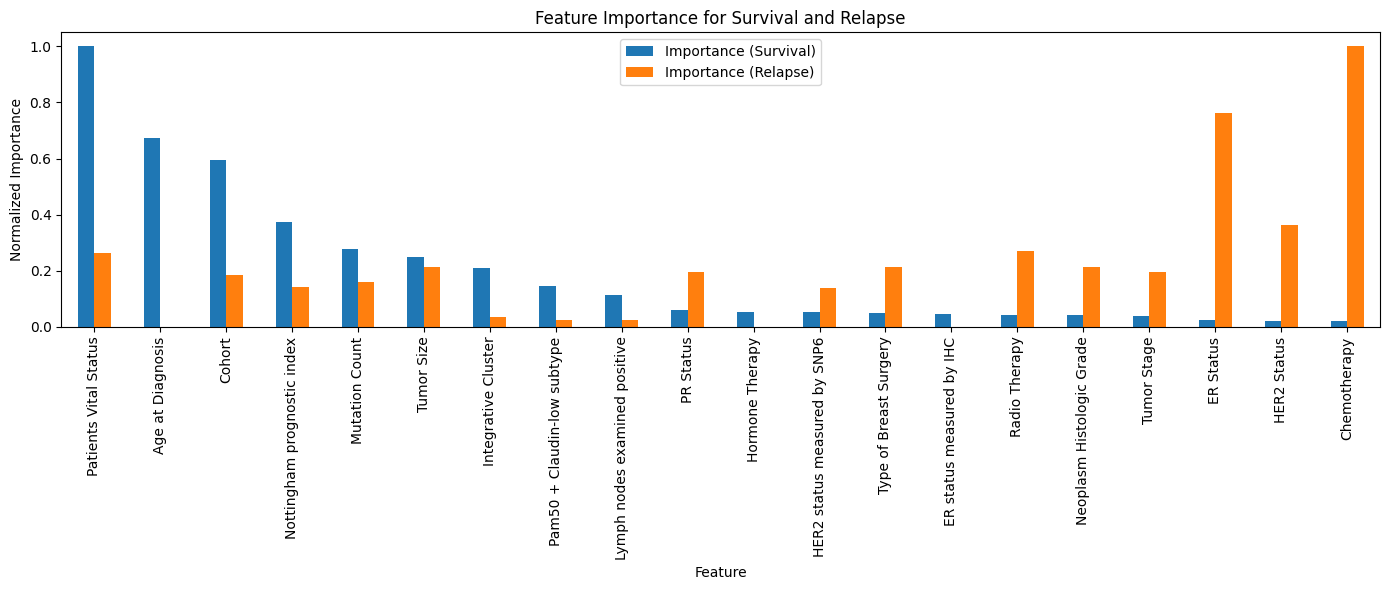

Top features contributing to survival and relapse:


,Feature,Importance (Survival),Importance (Relapse)
19,Patients Vital Status,1.000000,0.262656
0,Age at Diagnosis,0.673171,0.000000
17,Cohort,0.593337,0.186047
14,Nottingham prognostic index,0.373609,0.143307
15,Mutation Count,0.277203,0.160128
1,Tumor Size,0.249957,0.211976
18,Integrative Cluster,0.208729,0.033784
9,Pam50 + Claudin-low subtype,0.144853,0.023542
16,Lymph nodes examined positive,0.112662,0.024879
6,PR Status,0.061336,0.195726


In [9]:
# Dropping ID columns and non-contributory features
X = tumour_data.drop(columns=['Patient ID', target_survival, target_relapse])
y_survival = tumour_data[target_survival]
y_relapse = tumour_data[target_relapse]


# Feature Importance using Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y_survival)

# Get feature importances
importance_survival = rf_model.feature_importances_
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance (Survival)': importance_survival
}).sort_values(by='Importance (Survival)', ascending=False)

# Feature Importance using Mutual Information for Relapse
mi_relapse = mutual_info_regression(X, y_relapse)
importance_data['Importance (Relapse)'] = mi_relapse

# Normalize importances for easier comparison
importance_data['Importance (Survival)'] /= importance_data['Importance (Survival)'].max()
importance_data['Importance (Relapse)'] /= importance_data['Importance (Relapse)'].max()

# Plotting
plt.figure(figsize=(10, 8))
importance_data.set_index('Feature').plot(kind='bar', figsize=(14, 6))
plt.title('Feature Importance for Survival and Relapse')
plt.ylabel('Normalized Importance')
plt.tight_layout()
plt.show()

# Print top features
print("Top features contributing to survival and relapse:")
importance_data

In [15]:
columns_for_survival = [
    "Patient ID", 
    "Patients Vital Status", 
    "Age at Diagnosis", 
    "Cohort", 
    "Nottingham prognostic index", 
    "Mutation Count", 
    "Tumor Size", 
    "Integrative Cluster", 
    "Overall Survival (Months)"
]

survival_database = tumour_data[columns_for_survival]
survival_database.head()


,Patient ID,Patients Vital Status,Age at Diagnosis,Cohort,Nottingham prognostic index,Mutation Count,Tumor Size,Integrative Cluster,Overall Survival (Months)
1,MB-0002,2,43.19,1.0,4.020,2.0,10.0,4,84.633333
2,MB-0005,0,48.87,1.0,4.030,2.0,15.0,3,163.700000
3,MB-0006,2,47.68,1.0,4.050,1.0,25.0,10,164.933333
4,MB-0008,0,76.97,1.0,6.080,2.0,40.0,10,41.366667
5,MB-0010,0,78.77,1.0,4.062,4.0,31.0,8,7.800000


In [16]:
survival_database.to_csv("survival_database.csv")

In [17]:
columns_for_relapse = [
    "Patient ID",
    "ER Status",	
    "HER2 Status",	
    "Chemotherapy", 
    "Relapse Free Status (Months)"
]
relapse_database = tumour_data[columns_for_relapse]
relapse_database.head()

,Patient ID,ER Status,HER2 Status,Chemotherapy,Relapse Free Status (Months)
1,MB-0002,1,0,0,83.52
2,MB-0005,1,0,1,151.28
3,MB-0006,1,0,1,162.76
4,MB-0008,1,0,1,18.55
5,MB-0010,1,0,0,2.89


In [18]:

relapse_database.to_csv("relapse_database.csv")